## Random State Analysis 

# Imports

In [1]:
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier
from scipy.spatial import distance
from collections import Counter


from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import distance
import matplotlib.pyplot as plt
import itertools
import warnings
import shap
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu

import random

/Users/omrinewman/FinalProj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ensembling Class

In [ ]:
class Ensembling:
    def __init__(self, state):
        self.scaler = StandardScaler()
        self.random_state = state
        self.val_size = 0.15
        self.test_size = 0.10
        self.n_jobs = 1 #-1
        self.model_configs = None
        self.best_models = None
        self.results_df = None
        self.roc_data = None
        self.misclassified_samples = None
        self.confusion_matrices = None
        self.shap_cache = {}

    def split_data(self, X, y):
        """
        Split the data with specified training, validation, and test splits.

        Args:
        - X: The feature dataset.
        - y: The target variable.
        - final_test_size (float): Proportion of the dataset for the final evaluation.
        - base_test_size (float): Proportion of the dataset for testing base models.
        - meta_validation_size (float): Proportion of the dataset for training the meta model.
        """
        # Initial split: Separate out the final evaluation set
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        # Separate out the validation and train sets
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(self.val_size / (1 - self.test_size)), random_state=self.random_state)
        
        # Scaling numerical features
        numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] 
        # self.scaler.fit(X_train[numerical_cols])
        X_train_numerical = self.scaler.fit_transform(X_train[numerical_cols])
        X_val_numerical = self.scaler.transform(X_val[numerical_cols])
        X_test_numerical = self.scaler.transform(X_test[numerical_cols])
        
        # Combine scaled numerical features and one-hot encoded features
        X_train_scaled = pd.DataFrame(X_train_numerical, columns=numerical_cols, index=X_train.index).join(X_train.drop(columns=numerical_cols)).reset_index(drop=True)
        X_val_scaled = pd.DataFrame(X_val_numerical, columns=numerical_cols, index=X_val.index).join(X_val.drop(columns=numerical_cols)).reset_index(drop=True)
        X_test_scaled = pd.DataFrame(X_test_numerical, columns=numerical_cols, index=X_test.index).join(X_test.drop(columns=numerical_cols)).reset_index(drop=True)

        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    
    def generate_model_variants(self):
        """
        Prepares model configurations for use with GridSearchCV.
        """

        self.model_configs = {
            'Random Forest': {
                'model_class': RandomForestClassifier,
                'param_grid': {'n_estimators': [10, 50, 100, 150, 200]}
            },
            'XGBoost': {
                'model_class': XGBClassifier,
                'param_grid': {
                    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                    'n_estimators': [100],
                    'use_label_encoder': [False],
                    'eval_metric': ['logloss']
                }
            },
            'MLP': {
                'model_class': MLPClassifier,
                'param_grid': {
                    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
                    'learning_rate_init': [0.0005, 0.0001]
                }
            }
        }
    
    def select_best_variant(self, X_train, y_train, n_splits=5):
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        best_models = {}

        for model_name, config in self.model_configs.items():
            # print(f"\nEvaluating Baseline {model_name} variants on train set...")

            grid_search = GridSearchCV(
                estimator=config['model_class'](random_state=self.random_state),
                param_grid=config['param_grid'],
                scoring='f1',
                cv=kf,
                verbose=0, 
                n_jobs=self.n_jobs 
            )

            grid_search.fit(X_train, y_train)

            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_

            # print(f"Best variant for {model_name} found with Avg F1-Score {best_score:.4f} and params {best_params}")

            best_models[model_name] = {
                'model': best_model,
                'avg_f1_score': best_score,
                'params': best_params
            }

        self.best_models = best_models

    # def _evaluate_model_performance(self, model, X_test, y_test):
        
    #     """
    #     Helper function to evaluate the performance of a model on the test set.
        
    #     Args:
    #     - model: The machine learning model to be evaluated.
    #     - X_test: Test set features.
    #     - y_test: Test set labels.
        
    #     Returns:
    #     - A dictionary with performance metrics and misclassified sample indices.
    #     """
    #     y_pred = model.predict(X_test)
    #     y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
    #     roc_curve_data = {'fpr': None, 'tpr': None, 'roc_auc': None}

    #     if y_proba is not None:
    #         fpr, tpr, _ = roc_curve(y_test, y_proba)
    #         roc_auc = auc(fpr, tpr)
    #         roc_curve_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    #     metrics = {
    #         'Accuracy': accuracy_score(y_test, y_pred),
    #         'Precision': precision_score(y_test, y_pred),
    #         'Recall': recall_score(y_test, y_pred),
    #         'F1-Score': f1_score(y_test, y_pred),
    #         'ROC AUC': roc_auc if y_proba is not None else None
    #     }

    #     conf_matrix = confusion_matrix(y_test, y_pred)
    #     misclassified_indices = np.where(y_test != y_pred)[0]


    #     return {
    #         'metrics': metrics,
    #         'roc_curve_data': roc_curve_data,
    #         'conf_matrix': conf_matrix,
    #         'misclassified_indices': misclassified_indices
    #     }
    
    def _evaluate_model_performance(self, model, X_test, y_test):
        """
        Helper function to evaluate the performance of a model on the test set.
        """
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        roc_curve_data = {'fpr': None, 'tpr': None, 'roc_auc': None}
        pr_curve_data = {'precision': None, 'recall': None, 'pr_auc': None}

        if y_proba is not None:
            try:
                # Compute ROC Curve
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = auc(fpr, tpr)
                roc_curve_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

                # Compute Precision-Recall Curve
                precision, recall, _ = precision_recall_curve(y_test, y_proba)
                pr_auc = auc(recall, precision)  # AUC for PR is Recall -> Precision
                pr_curve_data = {'precision': precision, 'recall': recall, 'pr_auc': pr_auc}
            
            except Exception as e:
                print(f"Warning: PR AUC computation failed for model {model}. Error: {e}")
                pr_auc = None  # Ensure it's explicitly set

        else:
            print(f"Warning: {model} does not support predict_proba(), setting PR AUC to None.")
            pr_auc = None  # Set explicitly if model does not support probability outputs

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc if y_proba is not None else None,
            'PR AUC': pr_auc  # Ensure PR AUC is always defined
        }

        conf_matrix = confusion_matrix(y_test, y_pred)
        misclassified_indices = np.where(y_test != y_pred)[0]

        return {
            'metrics': metrics,
            'roc_curve_data': roc_curve_data,
            'pr_curve_data': pr_curve_data,  # Ensure PR curve data is passed along
            'conf_matrix': conf_matrix,
            'misclassified_indices': misclassified_indices
        }


    
    def evaluate_best_variant_on_validation(self, X_train, y_train, X_val, y_val):
        """
        Evaluate the best model variants on the validation set and store results.
        
        This method iterates over the best model variants, calls `evaluate_model_performance` for each,
        and then stores the results in the respective class attributes.
        
        Args:
        - X_train: Training set features.
        - y_train: Training set labels.
        - X_val: Validation set features.
        - y_val: Validation set labels.
        """
        performance_data = []

        for model_name, model_info in self.best_models.items():
            model = model_info['model']
            model.fit(X_train, y_train)
            
            evaluation = self._evaluate_model_performance(model, X_val, y_val)
            evaluation['Model'] = model_name
            performance_data.append(evaluation)

        self.misclassified_samples = {
            data['Model']: {'indices': data['misclassified_indices']} for data in performance_data
        }
    
    def evaluate_base_models_on_test(self, X_train, y_train, X_test, y_test):
        """
        Evaluate the best model variants on the test set and return results.
        
        This method iterates over the best model variants, calls `_evaluate_model_performance` for each,
        and then stores the results in the respective class attributes.
        
        Args:
        - X_train: Training set features.
        - y_train: Training set labels.
        - X_test: Test set features.
        - y_test: Test set labels.
        """

        performance_data = {}

        for model_name, model_info in self.best_models.items():
            model = model_info['model']
            model.fit(X_train, y_train)
            performance_data[model_name] = self._evaluate_model_performance(model, X_test, y_test)

        return performance_data
    
    def _extract_best_models(self):
        """
        Extracts the 'model' attribute from each entry in the best_models dictionary. 
        """
        models = {}
        for model_name, model_info in self.best_models.items():
            models[model_name] = model_info['model']
        return models
    
    def _extract_feature_importance(self):
        """
        Extracts the XGBoost feature importance from the best variant baseline model.  
        """
        best_model_instances = self._extract_best_models()
        feature_importances = best_model_instances['XGBoost'].feature_importances_
        return feature_importances
 
    def _extract_unique_misclassified_samples(self, X_val):
        """
        Extracts the unique misclassified samples of each baseline model from X_val into a dictionary for easier comparison
        with samples from X_test. 
        """
        # Use set intersection to find common misclassified samples across all models
        common_misclassified_indices = set(self.misclassified_samples[next(iter(self.misclassified_samples))]['indices'])
        for model in self.misclassified_samples:
            common_misclassified_indices.intersection_update(self.misclassified_samples[model]['indices'])

        # Remove the common misclassified indices from each model's misclassified list
        unique_samples = {}
        for model in self.misclassified_samples:
            unique_indices = set(self.misclassified_samples[model]['indices']) - common_misclassified_indices
            unique_samples[model] = {'indices': np.array(list(unique_indices))}

        # Use unique lists of misclassified sample indices to retrieve the correct data from the first test set
        misclassified_dict = {}
        for model in unique_samples.keys():
            misclassified_dict[model] = X_val.iloc[unique_samples[model]['indices']]
        
        return misclassified_dict

    def _calculate_weighted_median_distances(self, X_val, X_test):
        """
        Calculate the Euclidean distances from each sample in the test set to the median of
        misclassified samples, weighted by feature importances.

        Returns:
            dict: A dictionary with model names as keys and a list of distances for each test sample as values.
        """

        feature_importances = self._extract_feature_importance()
        misclassified_dict = self._extract_unique_misclassified_samples(X_val)

        weighted_distance_dict = {model: [] for model in misclassified_dict}

        # Calculate the median for each model's misclassified samples
        misclassified_medians = {model: features.median(axis=0) for model, features in misclassified_dict.items()}

        # Iterate over each test sample
        for _, sample in X_test.iterrows():
            # Reshape the sample to be a 2D array for distance calculation
            sample_array = sample.values.reshape(1, -1)

            # Calculate weighted distances to medians
            for model, median in misclassified_medians.items():
                # Ensure median is a 2D array
                median_array = median.values.reshape(1, -1) * feature_importances
                sample_array_weighted = sample_array * feature_importances
                sample_array_weighted = np.array(sample_array_weighted, dtype=float)
                
                # Calculate the weighted distance
                weighted_distance = distance.cdist(sample_array_weighted, median_array, 'euclidean')[0]
                
                # Append the distance to the corresponding model list in weighted_distance_dict
                weighted_distance_dict[model].append(weighted_distance[0])

        return weighted_distance_dict
    
    def _calculate_weights_from_distances(self, distances_dict):
        """
        Calculate normalized weights from distances for each test sample.

        Args:
            distances_dict (dict): A dictionary where keys are model names and values are lists of distances for each test sample.

        Returns:
            dict: A dictionary with normalized weights for each model, corresponding to each test sample.
        """
        # Initialize a dictionary to store the normalized weights for each model
        normalized_weights_dict = {model: [] for model in distances_dict}
        
        # Get the total number of samples
        num_samples = len(next(iter(distances_dict.values())))
        
        # Normalize weights for each sample across all models
        for i in range(num_samples):
            # Gather distances for sample i from each model
            sample_distances = np.array([distances_dict[model][i] for model in distances_dict])
            # Normalize weights so they sum to 1
            normalized_weights = sample_distances / np.sum(sample_distances)
            # Assign normalized weights back to each model for sample i
            for j, model in enumerate(distances_dict):
                normalized_weights_dict[model].append(normalized_weights[j])
        
        return normalized_weights_dict

    def _weighted_pred_and_proba(self, X_test, weights):
        """
        Calculate the wighted ensemble predicted probabilities and predictions.

        Args:
        - X_test: Test set features.
        - weights: Dictionary of weights for each model.

        Returns:
        - Tuple of two elements: (ensemble_predictions, ensemble_probabilities)
        """
        best_model_instances = self._extract_best_models()

        # Extracts probabilities for each model that the new samples belong to class 1
        probas = {model: [] for model in best_model_instances}
        for model_name, model in best_model_instances.items():
            probas[model_name] = model.predict_proba(X_test)[:, 1]

        ensemble_predictions = []
        ensemble_probabilities = []

        for i in range(len(next(iter(probas.values())))):
            weighted_sum = 0

            # For each model, multiply its predicted probability by its weight for the current sample
            for model in probas:
                weighted_sum += probas[model][i] * weights[model][i]

            ensemble_probabilities.append(weighted_sum)

            # If the weighted sum is greater than 0.5, predict 1, otherwise predict 0
            prediction = 1 if weighted_sum > 0.5 else 0
            ensemble_predictions.append(prediction)

        return ensemble_predictions, ensemble_probabilities

    # def _evaluate_weighted_ensemble_performance(self, y_pred, y_proba, y_test):
    #     """
    #     Evaluate the performance of a model on the test set.
    #     """
        
    #     roc_curve_data = {'fpr': None, 'tpr': None, 'roc_auc': None}

    #     if y_proba is not None:
    #         fpr, tpr, _ = roc_curve(y_test, y_proba)
    #         roc_auc = auc(fpr, tpr)
    #         roc_curve_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    #     metrics = {
    #         'Accuracy': accuracy_score(y_test, y_pred),
    #         'Precision': precision_score(y_test, y_pred),
    #         'Recall': recall_score(y_test, y_pred),
    #         'F1-Score': f1_score(y_test, y_pred),
    #         'ROC AUC': roc_auc if y_proba is not None else None
    #     }

    #     conf_matrix = confusion_matrix(y_test, y_pred)
    #     misclassified_indices = np.where(y_test != y_pred)[0]

    #     return {
    #         'metrics': metrics,
    #         'roc_curve_data': roc_curve_data,
    #         'conf_matrix': conf_matrix,
    #         'misclassified_indices': misclassified_indices
    #     }

    def _evaluate_weighted_ensemble_performance(self, y_pred, y_proba, y_test):
        """
        Evaluate the performance of the weighted ensemble model on the test set.
        """
        roc_curve_data = {'fpr': None, 'tpr': None, 'roc_auc': None}
        pr_curve_data = {'precision': None, 'recall': None, 'pr_auc': None}

        roc_auc, pr_auc = None, None

        if y_proba is not None:
            try:
                # Compute ROC Curve
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = auc(fpr, tpr)
                roc_curve_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

                # Compute Precision-Recall Curve
                precision, recall, _ = precision_recall_curve(y_test, y_proba)
                pr_auc = auc(recall, precision)  # PR AUC integrates Recall -> Precision
                pr_curve_data = {'precision': precision, 'recall': recall, 'pr_auc': pr_auc}
            
            except Exception as e:
                print(f"Warning: PR AUC computation failed for Weighted Ensemble. Error: {e}")

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc if y_proba is not None else None,
            'PR AUC': pr_auc if y_proba is not None else None
        }

        conf_matrix = confusion_matrix(y_test, y_pred)
        misclassified_indices = np.where(y_test != y_pred)[0]

        return {
            'metrics': metrics,
            'roc_curve_data': roc_curve_data,
            'pr_curve_data': pr_curve_data,  # Ensure PR data is included
            'conf_matrix': conf_matrix,
            'misclassified_indices': misclassified_indices
        }


    def _generate_meta_features(self, X):
        """
        Generate meta-features using the best variants of the base models.
        This function predicts with each base model and stacks the predictions.
        Args:
        - X: Data to generate meta-features for (either X_val_scaled or X_test_scaled).
        Returns:
        - A numpy array of meta-features.
        """
        meta_features = []
        for model_info in self.best_models.values():
            model = model_info['model']
            predictions = model.predict_proba(X)[:, 1] 
            meta_features.append(predictions)
        
        return np.column_stack(meta_features)

    def evaluate_meta_model_with_cv(self, X_val, y_val, X_test, y_test, n_splits=5):
        """
        Trains a meta-model with cross-validation and evaluates its performance.
        Args:
        - X_val, y_val: Validation features and labels for training the meta-model.
        - X_test, y_test: Test features and labels for evaluating the meta-model.
        - n_splits: Number of splits for cross-validation.
        Returns:
        - A dictionary with performance metrics and the trained meta-model.
        """
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs']
        }
        
        grid_search = GridSearchCV(
            LogisticRegression(max_iter=10000),
            param_grid=param_grid,
            cv=kf,
            scoring='f1',
            verbose=0,
            n_jobs=self.n_jobs
        )
        
        # Generate meta-features for the validation set
        X_meta_val = self._generate_meta_features(X_val)
        
        # Perform the grid search
        grid_search.fit(X_meta_val, y_val)
        
        best_model = grid_search.best_estimator_
        
        # Generate meta-features for the test set
        X_meta_test = self._generate_meta_features(X_test)
        blended_ensemble_performance = self._evaluate_model_performance(best_model, X_meta_test, y_test)
        
        # Include the best model in the result dictionary for further analysis
        blended_ensemble_performance['model'] = best_model  # Add the best model to the performance dictionary
        
        return blended_ensemble_performance


    def run_weighted_ensemble(self, X_val, X_test, y_test):
        """
        Run the weighted ensemble on the test set and calculate performance.
        """
        # print(f"Starting weighted ensemble run on random state {self.random_state}")

        # Calculate distances and weights for weighted ensemble
        distances_dict = self._calculate_weighted_median_distances(X_val, X_test)
        weights_dict = self._calculate_weights_from_distances(distances_dict)

        # Get predictions and probabilities for weighted ensemble
        weighted_ensemble_pred, weighted_ensemble_proba = self._weighted_pred_and_proba(X_test, weights_dict)
        weighted_ensemble_performance = self._evaluate_weighted_ensemble_performance(weighted_ensemble_pred, weighted_ensemble_proba, y_test)

        return weighted_ensemble_performance
    
    def run_models(self, X, y, n_splits=5):
            """
            Run the pipeline for training and evaluating the base models, weighted ensemble, and blended ensemble.
            
            Args:
            - X, y: Features and target variable.
            - n_splits: Number of splits for cross-validation in the meta model.
            
            Returns:
            - A dictionary containing the performance metrics and SHAP values for each ensemble model and base models.
            """
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

            # Generate model variants and select best model variant
            self.generate_model_variants()
            self.select_best_variant(X_train, y_train, n_splits=n_splits)
            self.evaluate_best_variant_on_validation(X_train, y_train, X_val, y_val)
            base_performance = self.evaluate_base_models_on_test(X_train, y_train, X_test, y_test)

        
            # Run weighted ensemble and calculate SHAP values
            weighted_ensemble_performance = self.run_weighted_ensemble(X_val, X_test, y_test)

            # Run blended ensemble (meta model) and calculate SHAP values for the meta model
            blended_ensemble_performance = self.evaluate_meta_model_with_cv(X_val, y_val, X_test, y_test, n_splits=n_splits)
            blended_model = blended_ensemble_performance['model']  # Get the best meta-model

            # Generate meta-features for validation set
            X_meta_val = self._generate_meta_features(X_val)

            return {
                "weighted_ensemble_performance": weighted_ensemble_performance,
                "blended_ensemble_performance": blended_ensemble_performance,
                "base_performance": base_performance,
            }

    def run_pipeline(self, random_states, df):
        """
        Run pipeline for each state in random_states and store results in dictionaries.
        """
        # Preprocess data by creating dummy variables
        dummy_df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'FastingBS', 
                                            'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
        X = dummy_df.drop('HeartDisease', axis=1)
        y = dummy_df['HeartDisease']

        # Dictionaries to store performance metrics
        weighted_ensemble_dict = {}
        blended_ensemble_dict = {}
        baseline_dict = {}

        # Run pipeline for each random state
        for state in random_states:
            # Reset the random state and clear SHAP cache for each iteration
            self.random_state = state

            # Run the models for this random state, capturing performance and SHAP values
            results = self.run_models(X, y)

            # Store performance metrics in dictionaries
            weighted_ensemble_dict[state] = results["weighted_ensemble_performance"]
            blended_ensemble_dict[state] = results["blended_ensemble_performance"]
            baseline_dict[state] = results["base_performance"]



        return weighted_ensemble_dict, blended_ensemble_dict, baseline_dict


    def consolidate_performance_metrics(self, weighted_ensemble_dict, blended_ensemble_dict, baseline_dict):
            """
            Consolidates performance metrics across random states for each model into a DataFrame.
            """
            data_list = []

            # Assuming the same random states are available across all dictionaries
            random_states = weighted_ensemble_dict.keys()
            
            for random_state in random_states:
                # Add metrics for the weighted ensemble
                for model_name, model_dict in [
                    ('Weighted Ensemble', weighted_ensemble_dict),
                    ('Blended Ensemble', blended_ensemble_dict)
                ]:
                    metrics = model_dict[random_state]['metrics']
                    data_list.append({
                        'Random State': random_state,
                        'Model': model_name,
                        'Accuracy': metrics['Accuracy'],
                        'Precision': metrics['Precision'],
                        'Recall': metrics['Recall'],
                        'F1-Score': metrics['F1-Score'],
                        'ROC AUC': metrics['ROC AUC'],
                        'PR AUC': metrics.get('PR AUC', None)  # Fix: Ensure no KeyError
                    })

                # Add metrics for each baseline model
                for model_name in baseline_dict[random_state]:
                    metrics = baseline_dict[random_state][model_name]['metrics']
                    data_list.append({
                        'Random State': random_state,
                        'Model': model_name.replace('_', ' '),
                        'Accuracy': metrics['Accuracy'],
                        'Precision': metrics['Precision'],
                        'Recall': metrics['Recall'],
                        'F1-Score': metrics['F1-Score'],
                        'ROC AUC': metrics['ROC AUC'],
                        'PR AUC': metrics.get('PR AUC', None)  # Fix: Ensure no KeyError
                    })

            # Convert the list of dictionaries to a pandas DataFrame
            return pd.DataFrame(data_list)


# Run Ensemble (no shap or plotting)

In [3]:

warnings.filterwarnings("ignore")

# Step 1: Load your dataset
df = pd.read_csv("../data/heart.csv")

# Step 2: Define your list of random states (reduced for quicker runs if needed)
# random.seed(9)
# random_states = [random.randint(1, 200) for _ in range(5)]

# good combination of states
# random_states = [ 47,  74,  96, 129, 187]
random_states = [ 71,  84, 100, 163, 193]
# [20, 30, 197, 105, 120] seed 67


# random_states = list(range(1, 201))
# random_states.remove(78)  # Remove problematic random state


# Step 3: Initialize the Ensembling class
ensemble = Ensembling(state=0)  # Initialize with any random state; it will be reset in the method

# Step 4: Run the pipeline across multiple random states
weighted_ensemble_dict, blended_ensemble_dict, baseline_dict = ensemble.run_pipeline(random_states, df)

# Step 5: Aggregate and analyze the results
# Consolidate performance metrics into a single DataFrame
performance_metrics_df = ensemble.consolidate_performance_metrics(
    weighted_ensemble_dict=weighted_ensemble_dict,
    blended_ensemble_dict=blended_ensemble_dict,
    baseline_dict=baseline_dict
)


In [4]:
performance_metrics_df

,Random State,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,71,Weighted Ensemble,0.847826,0.842105,0.905660,0.872727,0.922109,0.933936
1,71,Blended Ensemble,0.847826,0.830508,0.924528,0.875000,0.917271,0.930973
2,71,Random Forest,0.836957,0.827586,0.905660,0.864865,0.911950,0.927873
3,71,XGBoost,0.826087,0.849057,0.849057,0.849057,0.912917,0.930240
4,71,MLP,0.815217,0.833333,0.849057,0.841121,0.916788,0.932827
5,84,Weighted Ensemble,0.880435,0.879310,0.927273,0.902655,0.954791,0.969026
6,84,Blended Ensemble,0.869565,0.852459,0.945455,0.896552,0.950369,0.964965
7,84,Random Forest,0.869565,0.864407,0.927273,0.894737,0.954054,0.958998
8,84,XGBoost,0.858696,0.862069,0.909091,0.884956,0.936118,0.957711
9,84,MLP,0.869565,0.877193,0.909091,0.892857,0.932678,0.951116


In [5]:
# performance_metrics_df.to_csv('random_states_no_fit_transform.csv', index=False)

In [6]:
median_performance_df = performance_metrics_df.groupby('Model').median(numeric_only=True).drop('Random State', axis=1)
median_performance_df.columns = [f"median_{col}" for col in median_performance_df.columns]
median_performance_df.reindex(
    ['MLP', 'XGBoost', 'Random Forest', 'Blended Ensemble', 'Weighted Ensemble']
)


,median_Accuracy,median_Precision,median_Recall,median_F1-Score,median_ROC AUC,median_PR AUC
Model,,,,,,
MLP,0.869565,0.865385,0.909091,0.891089,0.916788,0.940277
XGBoost,0.847826,0.854839,0.892857,0.865385,0.912917,0.932287
Random Forest,0.858696,0.862745,0.897959,0.880000,0.911950,0.943961
Blended Ensemble,0.869565,0.851852,0.924528,0.893204,0.917271,0.943528
Weighted Ensemble,0.880435,0.867925,0.910714,0.901961,0.922109,0.943092


# All States Analysis

In [35]:
all_states_no_fit = pd.read_csv('../data/random_states_no_fit_transform.csv')
all_states_no_fit

,Random State,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,1,Weighted Ensemble,0.934783,0.962264,0.927273,0.944444,0.965602,0.969649
1,1,Blended Ensemble,0.923913,0.961538,0.909091,0.934579,0.961671,0.969293
2,1,Random Forest,0.913043,0.943396,0.909091,0.925926,0.956265,0.964763
3,1,XGBoost,0.923913,0.944444,0.927273,0.935780,0.953808,0.951361
4,1,MLP,0.891304,0.941176,0.872727,0.905660,0.956757,0.965432
...,...,...,...,...,...,...,...,...
990,200,Weighted Ensemble,0.869565,0.838710,0.962963,0.896552,0.917641,0.933278
991,200,Blended Ensemble,0.869565,0.838710,0.962963,0.896552,0.920565,0.934773
992,200,Random Forest,0.869565,0.838710,0.962963,0.896552,0.923489,0.937350
993,200,XGBoost,0.847826,0.833333,0.925926,0.877193,0.923002,0.930864


In [36]:
all_states_no_fit.groupby('Model').median(numeric_only=True).drop('Random State', axis=1).reindex(
    ['MLP', 'XGBoost', 'Random Forest', 'Blended Ensemble', 'Weighted Ensemble']
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
Model,,,,,,
MLP,0.869565,0.864407,0.895833,0.877551,0.932765,0.939265
XGBoost,0.858696,0.857143,0.888889,0.876190,0.924311,0.930240
Random Forest,0.869565,0.862069,0.901961,0.882883,0.925000,0.934480
Blended Ensemble,0.869565,0.857143,0.916667,0.886792,0.933333,0.938133
Weighted Ensemble,0.869565,0.865385,0.901961,0.884615,0.931328,0.940111


In [37]:
def count_top_models_by_metric(df, metric, top_n):
    """
    Calculates the percentage of times each model appears in the top N entries 
    for a specified performance metric.

    Args:
    - df (pd.DataFrame): DataFrame containing model performance metrics.
    - metric (str): The performance metric to sort by (e.g., 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC').
    - top_n (int): The number of top entries to consider.

    Returns:
    - pd.DataFrame: A DataFrame with the percentage of top entries for each model.
    """
    # Sort by the specified metric in descending order and select the top N rows
    top_metric_df = df.sort_values(metric, ascending=False).iloc[:top_n].reset_index(drop=True)
    
    # Count occurrences of each model in the top N rows
    count_top_metric = top_metric_df.groupby('Model').size()
    
    # Reorder to ensure consistent ordering of models
    count_top_metric = count_top_metric.reindex(['MLP', 'XGBoost', 'Random Forest', 'Blended Ensemble', 'Weighted Ensemble'], fill_value=0)
    
    # Calculate the percentage and format with a `%` sign
    percentage_top_metric = (count_top_metric / top_n * 100).round().astype(int).astype(str) + '%'
    
    # Return as a DataFrame with the metric as the column header
    return pd.DataFrame({metric: percentage_top_metric})




In [38]:
top_n = 50
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']

percent_dfs = [count_top_models_by_metric(all_states_no_fit, metric, top_n=top_n) for metric in metrics]
combined_percentages = pd.concat(percent_dfs, axis=1)

print(f'Top {top_n} Ranking Percentage Table')
combined_percentages

Top 50 Ranking Percentage Table


,Precision,Recall,F1-Score,ROC AUC,PR AUC
Model,,,,,
MLP,22%,16%,20%,18%,22%
XGBoost,18%,16%,18%,12%,16%
Random Forest,14%,16%,18%,18%,16%
Blended Ensemble,14%,36%,22%,24%,22%
Weighted Ensemble,32%,16%,22%,28%,24%


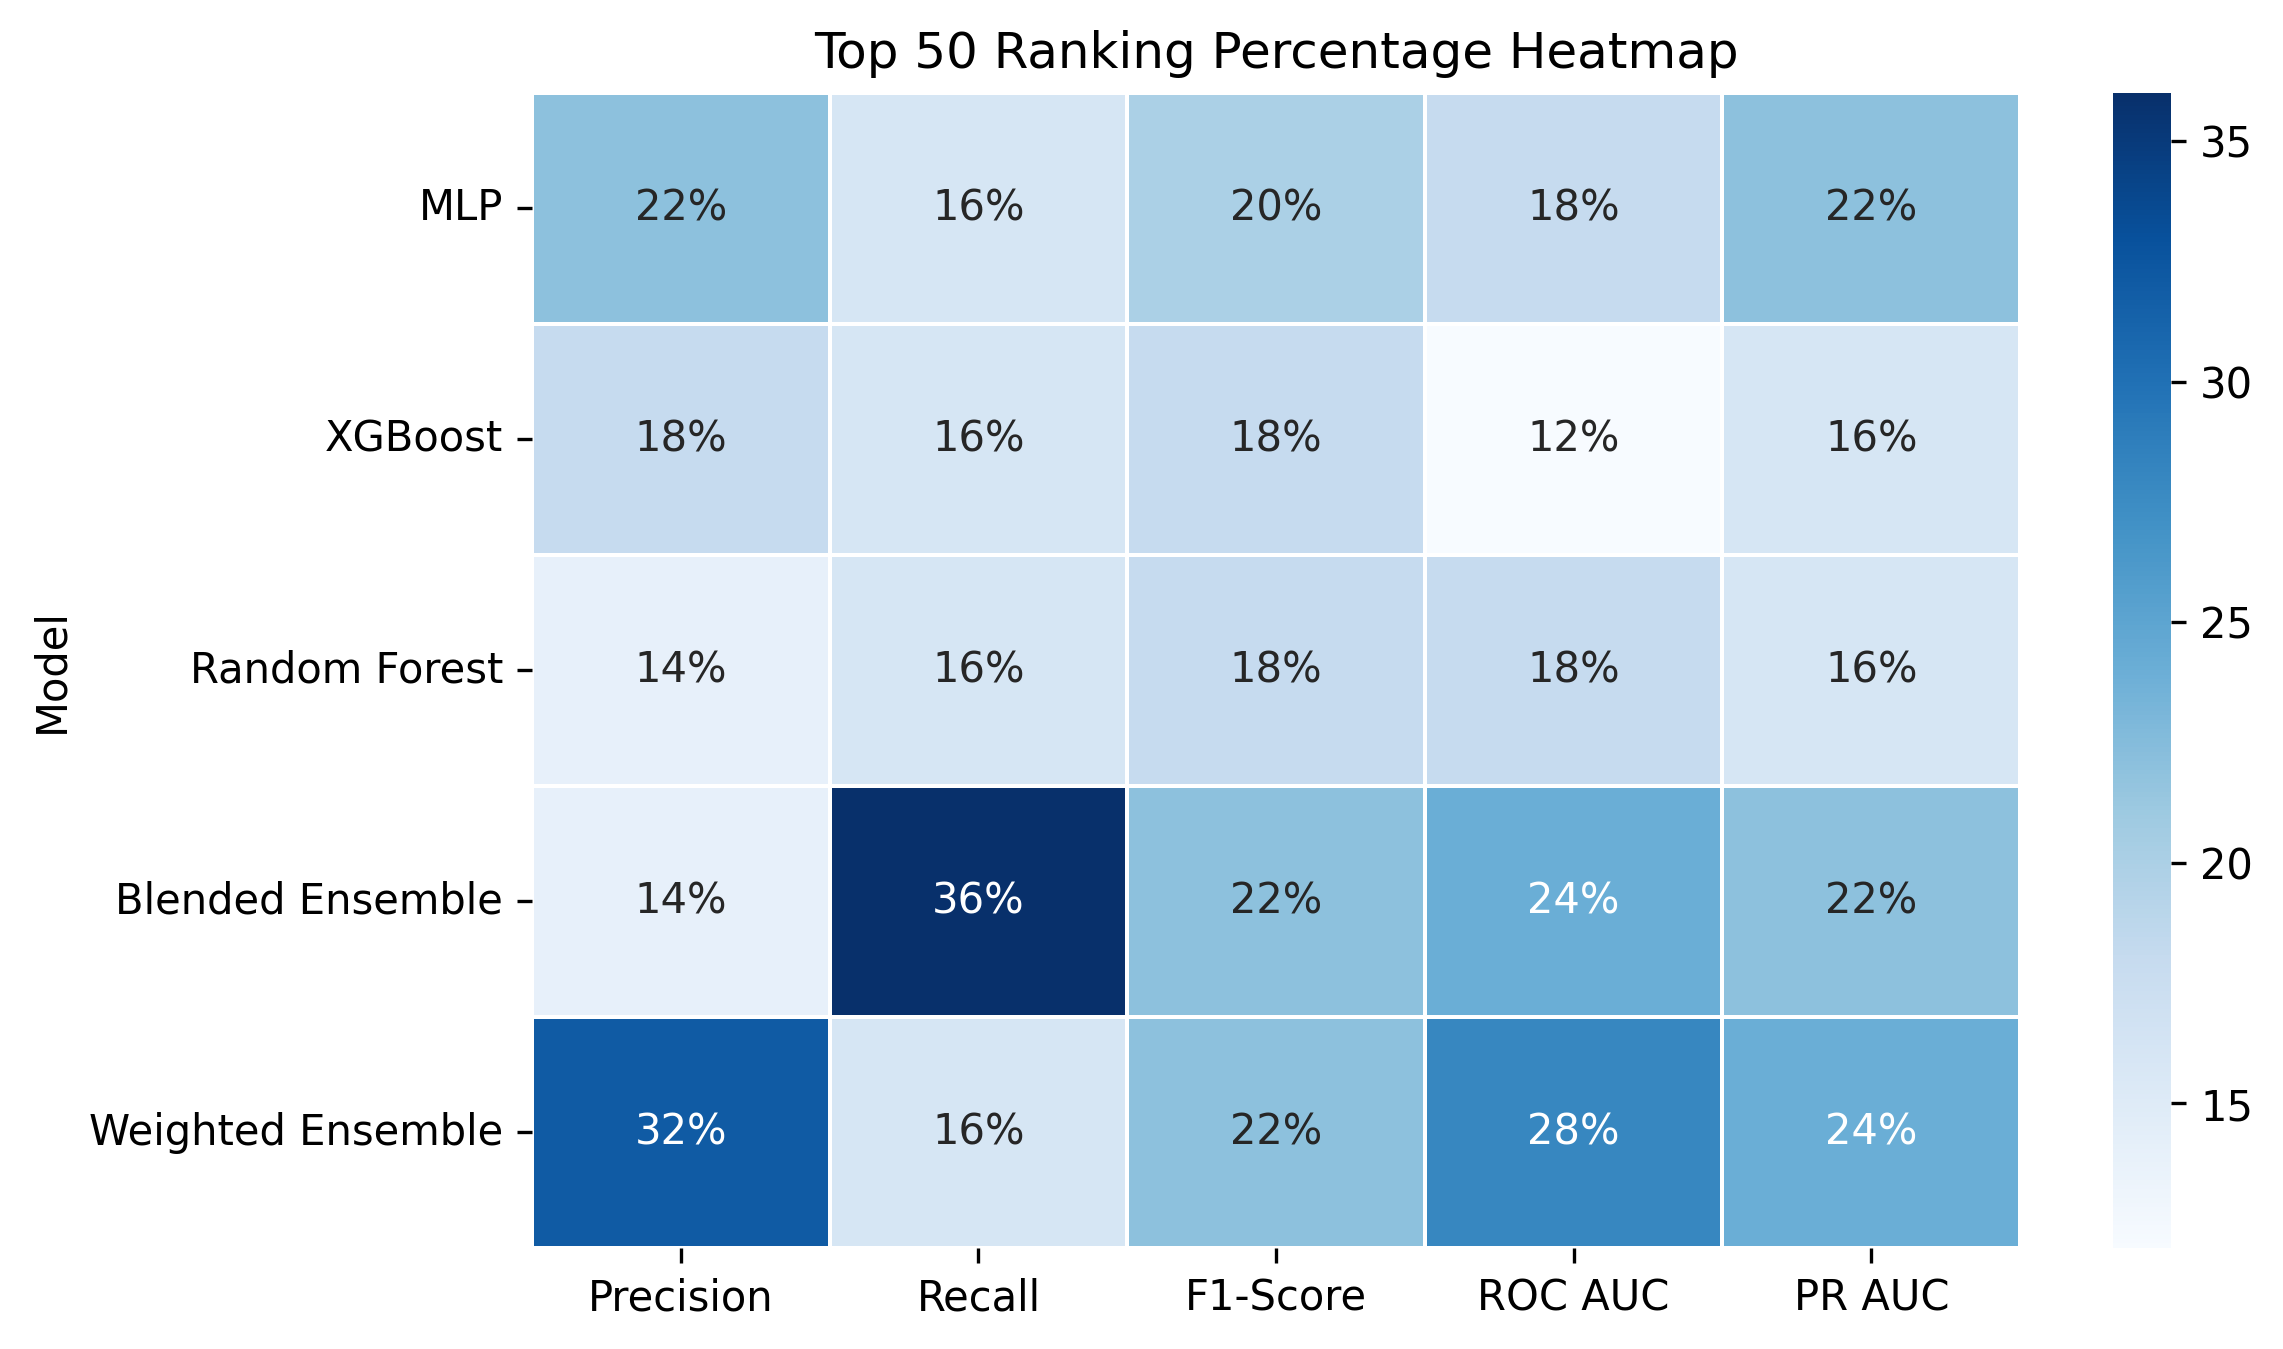

In [39]:
# Convert percentages to numeric for visualization
numeric_df = combined_percentages.applymap(lambda x: int(x.replace('%', '')))

plt.figure(figsize=(8, 5), dpi=300)
sns.heatmap(numeric_df, annot=numeric_df.applymap(lambda x: f"{x}%"), cmap="Blues", fmt="", linewidths=0.5)
plt.title(f"Top {top_n} Ranking Percentage Heatmap")
plt.show()


# Statistical Significance

In [13]:
all_states_no_fit

,Random State,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,1,Weighted Ensemble,0.934783,0.962264,0.927273,0.944444,0.965602,0.969649
1,1,Blended Ensemble,0.923913,0.961538,0.909091,0.934579,0.961671,0.969293
2,1,Random Forest,0.913043,0.943396,0.909091,0.925926,0.956265,0.964763
3,1,XGBoost,0.923913,0.944444,0.927273,0.935780,0.953808,0.951361
4,1,MLP,0.891304,0.941176,0.872727,0.905660,0.956757,0.965432
...,...,...,...,...,...,...,...,...
990,200,Weighted Ensemble,0.869565,0.838710,0.962963,0.896552,0.917641,0.933278
991,200,Blended Ensemble,0.869565,0.838710,0.962963,0.896552,0.920565,0.934773
992,200,Random Forest,0.869565,0.838710,0.962963,0.896552,0.923489,0.937350
993,200,XGBoost,0.847826,0.833333,0.925926,0.877193,0.923002,0.930864


In [14]:
# Define models and metrics
base_models = ["MLP", "XGBoost", "Random Forest"]
ensemble_models = ["Blended Ensemble", "Weighted Ensemble"]
metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "PR AUC"]

# Ensure data is pivoted correctly: each column should be a model-metric pair
df_pivot = all_states_no_fit.pivot(index="Random State", columns="Model")

# Store results
wilcoxon_results = []

# Run Wilcoxon Signed-Rank Test for each metric and model pair
for metric in metrics:
    for ensemble in ensemble_models:
        for base in base_models:
            scores_ensemble = df_pivot[(metric, ensemble)].dropna()
            scores_base = df_pivot[(metric, base)].dropna()

            # Ensure equal number of samples
            min_length = min(len(scores_ensemble), len(scores_base))
            scores_ensemble, scores_base = scores_ensemble.iloc[:min_length], scores_base.iloc[:min_length]

            # Compute Wilcoxon test
            stat, p_value = wilcoxon(scores_ensemble, scores_base, alternative='greater')


            # Store results
            wilcoxon_results.append({
                "Metric": metric,
                "Ensemble Model": ensemble,
                "Base Model": base,
                "Wilcoxon p-value": p_value,
                "Significant (p<0.05)": p_value < 0.05
            })

# Convert results to DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results)

# Display results
wilcoxon_df


,Metric,Ensemble Model,Base Model,Wilcoxon p-value,Significant (p<0.05)
0,Precision,Blended Ensemble,MLP,9.987679e-01,False
1,Precision,Blended Ensemble,XGBoost,6.367539e-01,False
2,Precision,Blended Ensemble,Random Forest,9.790956e-01,False
3,Precision,Weighted Ensemble,MLP,1.990379e-01,False
4,Precision,Weighted Ensemble,XGBoost,7.886686e-05,True
5,Precision,Weighted Ensemble,Random Forest,5.714601e-03,True
6,Recall,Blended Ensemble,MLP,8.822509e-09,True
7,Recall,Blended Ensemble,XGBoost,1.534610e-12,True
8,Recall,Blended Ensemble,Random Forest,1.508157e-05,True
9,Recall,Weighted Ensemble,MLP,4.514161e-03,True


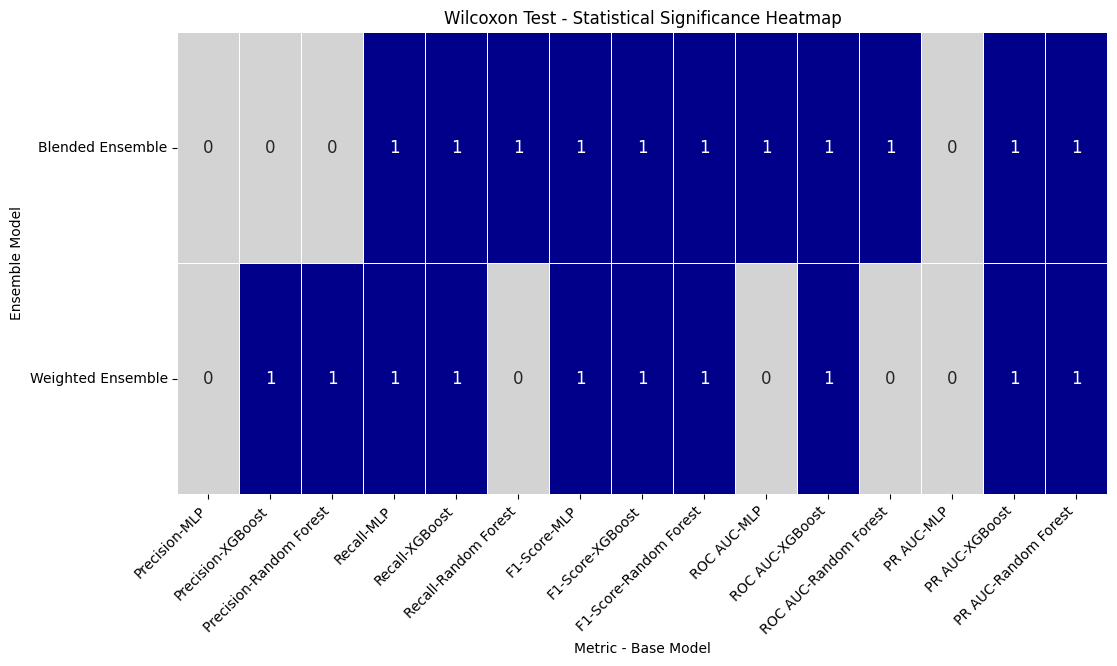

In [15]:
# Define significance threshold
alpha = 0.05  # Standard significance level

# Convert p-values into binary (1 = significant, 0 = not significant)
significance_mask = (wilcoxon_df.pivot(index="Ensemble Model", columns=["Metric", "Base Model"], values="Wilcoxon p-value") < alpha).astype(int)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(significance_mask, annot=True, cmap=["lightgray", "darkblue"], linewidths=0.5, cbar=False, 
            annot_kws={"size": 12}, fmt="d")

# Improve readability
plt.title("Wilcoxon Test - Statistical Significance Heatmap")
plt.xlabel("Metric - Base Model")
plt.ylabel("Ensemble Model")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show plot
plt.show()
